 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.autograd import Variable
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import torch.nn.functional as F
from torchvision import transforms

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))])  

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

In [ ]:
fashion_type = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat", 
  5: "Sandal", 
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [ ]:
len(trainset)

60000

In [ ]:
len(testset)

10000

In [ ]:
train_unique = trainset.targets.unique(return_counts=True)[1]
test_unique = testset.targets.unique(return_counts=True)[1]

In [ ]:
(torch.mean(test_unique[0].float()) == test_unique[0]).item()

True

In [ ]:
(torch.mean(train_unique[0].float()) == train_unique[0]).item()

True

T-shirt/top


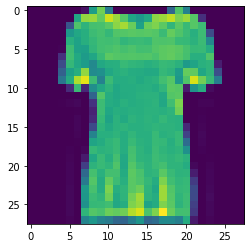

Bag


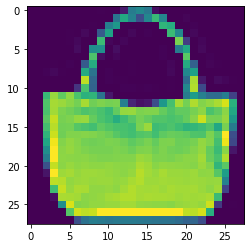

Dress


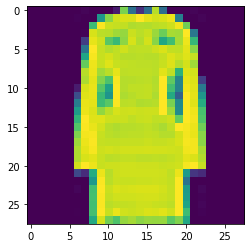

Trouser


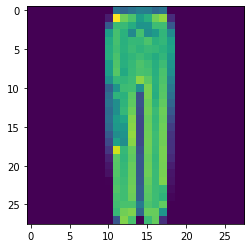

In [ ]:
for i in [10, 100, 500, 1000]:
  print(fashion_type[trainset.targets[i].item()])
  plt.imshow(trainset.data[i])
  plt.show()

In [ ]:
def fit(model, optimizer, loss_fn, epochs = 10):
  loss_values = []
  for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(trainloader):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      optimizer.zero_grad()
      loss = loss_fn(model(images), labels)
      loss.backward()
      optimizer.step()
      if(i == 1000):
        loss_values.append(loss.detach().cpu().item())
  plt.plot(loss_values)
  plt.show()

In [ ]:
def report(model, testloader):  
  model.eval()
  y_trues = []
  y_hats = []
  with torch.no_grad():
    for batch in testloader:
      y_pred = model(batch[0].cuda())
      y_hat = torch.argmax(y_pred, dim=1).detach().cpu()
      y_trues.extend(batch[1])
      y_hats.extend(y_hat)
  print(classification_report(y_hats, y_trues))

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = torch.nn.Linear(784, 256)
    self.act1 = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(256, 128)
    self.act2 = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(128, 10)
  
  def forward(self, x):
    x = x.view(-1, 784)
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

In [ ]:
model = MLP()

model.cuda()
model.train()

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/10 [00:00<?, ?it/s]

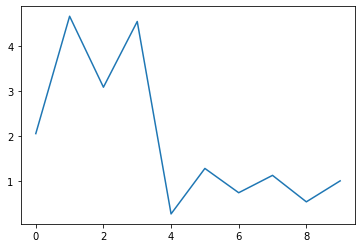

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1051
           1       0.96      0.99      0.98       970
           2       0.85      0.75      0.80      1138
           3       0.90      0.86      0.88      1048
           4       0.72      0.86      0.78       842
           5       0.94      0.97      0.96       964
           6       0.68      0.71      0.70       953
           7       0.95      0.93      0.94      1021
           8       0.96      0.98      0.97       985
           9       0.96      0.94      0.95      1028

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = torch.nn.Linear(256, 256)
    self.fc2 = torch.nn.Linear(256, 128)
    self.fc3 = torch.nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 4 * 4 * 16)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = CNN()

model.cuda()
model.train()

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

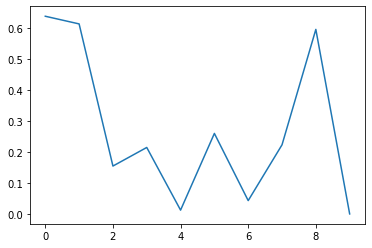

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       904
           1       0.98      0.99      0.98       983
           2       0.87      0.83      0.85      1049
           3       0.91      0.89      0.90      1015
           4       0.83      0.84      0.83       983
           5       0.96      0.98      0.97       980
           6       0.73      0.69      0.71      1052
           7       0.98      0.93      0.95      1058
           8       0.97      0.96      0.97      1009
           9       0.94      0.97      0.96       967

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)